# Analysis of mainnet transaction validation times

## Setup

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(VGAM, quietly=TRUE)
})

### Generate data

We use the `db-analyser` tool:

```bash
nix build 'github:IntersectMBO/ouroboros-consensus/release-ouroboros-consensus-diffusion-0.20.0.0#db-analyser'
```

Measure CPU usage starting from [Epoch 350](https://cardanoscan.io/block/7477993) and doing full application of blocks.

```bash
db-analyser \
  --db node.db/ \
  --analyse-from 65836843 \
  --benchmark-ledger-ops \
    --out-file ledger-ops-apply-65836843.csv \
  cardano --config node.json
```

Re-measure CPU usage but only reapplying blocks.

```bash
db-analyser \
  --db node.db/ \
  --analyse-from 65836843 \
  --benchmark-ledger-ops \
    --out-file ledger-ops-reapply-65836843.csv \
    --reapply \
  cardano --config node.json
```

The dominant difference between application and reapplication is the verification of transaction signatures and the execution of Plutus scripts.

<font color="red">WARNING: The measurements must be made on an otherwise idle machine because other CPU-heavy processes will interfere with the accuracy of `db-analyser`.</font>

## Read data

### Application

In [2]:
timingsApply <- fread("ledger-ops-apply-65836843.csv.gz")[
    `slot` >= 65836843, # Epoch 350
    .(
        `Slot`=`slot`,
        `Block [kB]`=`blockBytes`/1000,
        `Tx count`=as.numeric(`txs`),
        `Tx size [kB]`=txs_size/1000,
        `Tx exec [step]`=as.numeric(`txs_steps`),
        `Apply CPU [ms]`=`totalTime`/1000
    )
]
timingsApply %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836984   Min.   : 0.864   Min.   :  0.00   Min.   : 0.000  
 1st Qu.: 89833176   1st Qu.: 6.235   1st Qu.:  4.00   1st Qu.: 5.369  
 Median :113740091   Median :20.825   Median : 10.00   Median :19.962  
 Mean   :113666120   Mean   :31.091   Mean   : 14.19   Mean   :30.231  
 3rd Qu.:137528206   3rd Qu.:50.030   3rd Qu.: 21.00   3rd Qu.:49.175  
 Max.   :161151612   Max.   :90.061   Max.   :385.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]     
 Min.   :0.000e+00   Min.   :    0.255  
 1st Qu.:4.381e+08   1st Qu.:    2.087  
 Median :2.024e+09   Median :    5.593  
 Mean   :3.272e+09   Mean   :    8.202  
 3rd Qu.:5.067e+09   3rd Qu.:   11.468  
 Max.   :3.625e+10   Max.   :21960.779  

### Reapplication

In [3]:
timingsReapply <- fread("ledger-ops-reapply-65836843.csv.gz")[
    `slot` >= 65836843, # Epoch 350
    .(
        `Slot`=`slot`,
        `Reapply CPU [ms]`=`totalTime`/1000
    )
]
timingsReapply %>% summary

      Slot           Reapply CPU [ms]   
 Min.   : 65836984   Min.   :    0.046  
 1st Qu.: 89833176   1st Qu.:    0.357  
 Median :113740091   Median :    0.693  
 Mean   :113666120   Mean   :    1.205  
 3rd Qu.:137528206   3rd Qu.:    1.351  
 Max.   :161151612   Max.   :21445.038  

### Join the datasets

In [4]:
timings <- timingsApply[timingsReapply, on="Slot"]
timings[, `Apply - Reapply CPU [ms]`:=`Apply CPU [ms]`-`Reapply CPU [ms]`]
timings %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836984   Min.   : 0.864   Min.   :  0.00   Min.   : 0.000  
 1st Qu.: 89833176   1st Qu.: 6.235   1st Qu.:  4.00   1st Qu.: 5.369  
 Median :113740091   Median :20.825   Median : 10.00   Median :19.962  
 Mean   :113666120   Mean   :31.091   Mean   : 14.19   Mean   :30.231  
 3rd Qu.:137528206   3rd Qu.:50.030   3rd Qu.: 21.00   3rd Qu.:49.175  
 Max.   :161151612   Max.   :90.061   Max.   :385.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]      Reapply CPU [ms]   
 Min.   :0.000e+00   Min.   :    0.255   Min.   :    0.046  
 1st Qu.:4.381e+08   1st Qu.:    2.087   1st Qu.:    0.357  
 Median :2.024e+09   Median :    5.593   Median :    0.693  
 Mean   :3.272e+09   Mean   :    8.202   Mean   :    1.205  
 3rd Qu.:5.067e+09   3rd Qu.:   11.468   3rd Qu.:    1.351  
 Max.   :3.625e+10   Max.   :21960.779   Max.   :21445.038  
 Apply - Reapply CPU [ms]
 Min.   :-2073.664       
 1st Qu.:    1.65

### Sanity check

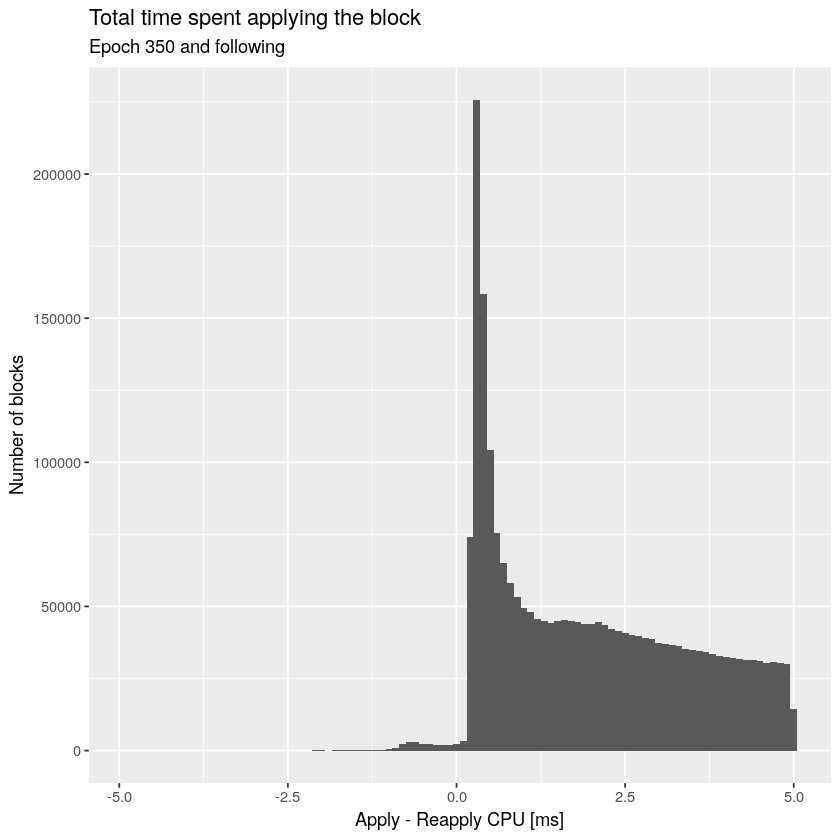

In [5]:
ggplot(timings[abs(`Apply - Reapply CPU [ms]`) < 5], aes(x=`Apply - Reapply CPU [ms]`)) +
    geom_histogram(binwidth=0.1) +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block",
        "Epoch 350 and following"
    )

From the above it appears that noisy measurements are not contaminating the results so much that we have many negative validation times.

### Cleanup

A few blocks have anomalously large times.

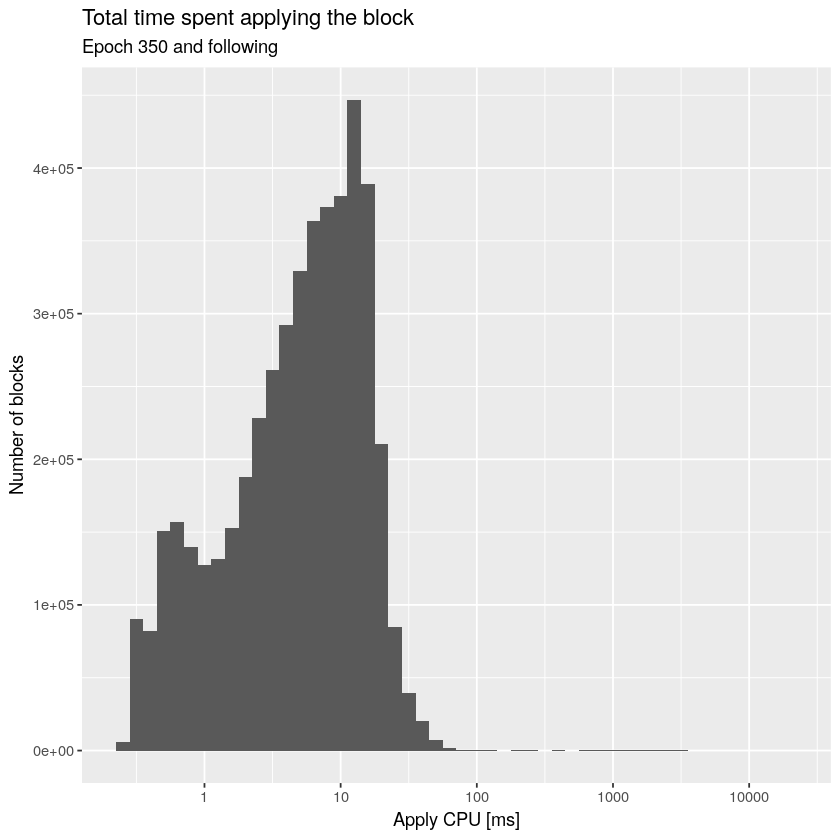

In [6]:
ggplot(timings, aes(x=`Apply CPU [ms]`)) +
    geom_histogram(binwidth=0.1) +
    scale_x_log10() +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block",
        "Epoch 350 and following"
    )

Ignore blocks that exceed the 99.9 %tile in CPU time because presumably there is something anomalous about these.

In [7]:
timeLimit <- timings[`Tx count` > 0, quantile(`Apply CPU [ms]`, 0.999)]
timeLimit

99.9% 
57.78926

## Basic statistics

In [8]:
basics <- timings[
    `Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`,
    .(
        `Apply CPU [ms/tx]`=`Apply CPU [ms]`/`Tx count`,
        `Reapply CPU [ms/tx]`=`Reapply CPU [ms]`/`Tx count`,
        `Delta CPU [ms/tx]`=(`Apply CPU [ms]`-`Reapply CPU [ms]`)/`Tx count`,
        `Apply CPU [ms/kB]`=`Apply CPU [ms]`/`Tx size [kB]`,
        `Reapply CPU [ms/kB]`=`Reapply CPU [ms]`/`Tx size [kB]`,
        `Delta CPU [ms/kB]`=(`Apply - Reapply CPU [ms]`)/`Tx size [kB]`
    ),
    .(
        `Slot`
    )
]
basics %>% summary

      Slot           Apply CPU [ms/tx]  Reapply CPU [ms/tx] Delta CPU [ms/tx]
 Min.   : 65836998   Min.   : 0.08147   Min.   :0.02209     Min.   : 0.0000  
 1st Qu.: 89315370   1st Qu.: 0.38163   1st Qu.:0.05340     1st Qu.: 0.3093  
 Median :112964767   Median : 0.52121   Median :0.06736     Median : 0.4365  
 Mean   :113100715   Mean   : 0.63114   Mean   :0.09047     Mean   : 0.5407  
 3rd Qu.:136901996   3rd Qu.: 0.73877   3rd Qu.:0.09767     3rd Qu.: 0.6451  
 Max.   :161151612   Max.   :39.24200   Max.   :7.91160     Max.   :35.5770  
 Apply CPU [ms/kB]  Reapply CPU [ms/kB] Delta CPU [ms/kB]
 Min.   : 0.01286   Min.   :0.002513    Min.   : 0.0000  
 1st Qu.: 0.18690   1st Qu.:0.023059    1st Qu.: 0.1584  
 Median : 0.26079   Median :0.037650    Median : 0.2191  
 Mean   : 0.39885   Mean   :0.071443    Mean   : 0.3274  
 3rd Qu.: 0.45389   3rd Qu.:0.071571    3rd Qu.: 0.3770  
 Max.   :42.44627   Max.   :5.040052    Max.   :42.1822  

### CPU time per transaction

In [9]:
melted <- melt(
    basics[, .(`Slot`, `Apply`=`Apply CPU [ms/tx]`, `Reapply`=`Reapply CPU [ms/tx]`, `Apply - Reapply`=`Delta CPU [ms/tx]`)],
    id.vars="Slot",
    measure.vars=c("Apply", "Reapply", "Apply - Reapply"),
    variable.name="Metric",
    value.name="CPU [ms/tx]"
)

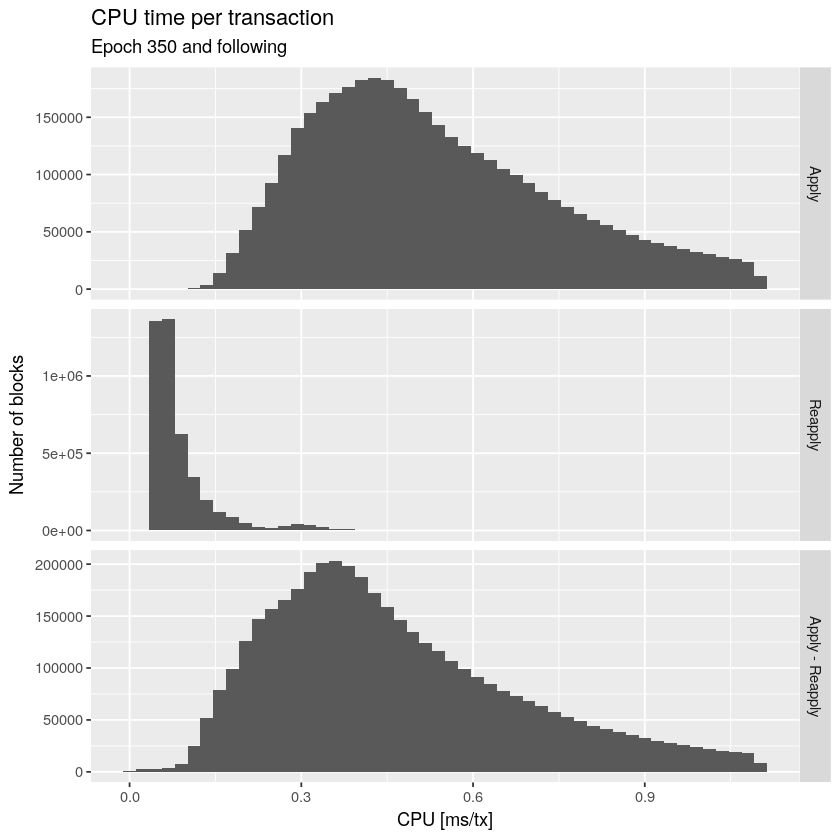

In [10]:
ggplot(melted[`CPU [ms/tx]` > 0 & `CPU [ms/tx]` < melted[, quantile(`CPU [ms/tx]`, 0.95)]], aes(x=`CPU [ms/tx]`)) +
    geom_histogram(bins=50) +
    ylab("Number of blocks") +
    facet_grid(`Metric` ~ ., scales="free_y") +
    ggtitle(
        "CPU time per transaction",
        "Epoch 350 and following"
    )

In [11]:
ggsave("cpu-per-tx.png", units="in", dpi=150, width=16, height=8)

In [12]:
melted[, .(`Median CPU [ms/tx]`=median(`CPU [ms/tx]`)), .(`Metric`)]

Metric,Median CPU [ms/tx]
<fct>,<dbl>
Apply,0.52120690
Reapply,0.06736364
Apply - Reapply,0.43650000


### CPU time per byte of transaction

In [13]:
melted <- melt(
    basics[, .(`Slot`, `Apply`=`Apply CPU [ms/kB]`, `Reapply`=`Reapply CPU [ms/kB]`, `Apply - Reapply`=`Delta CPU [ms/kB]`)],
    id.vars="Slot",
    measure.vars=c("Apply", "Reapply", "Apply - Reapply"),
    variable.name="Metric",
    value.name="CPU [ms/kB]"
)

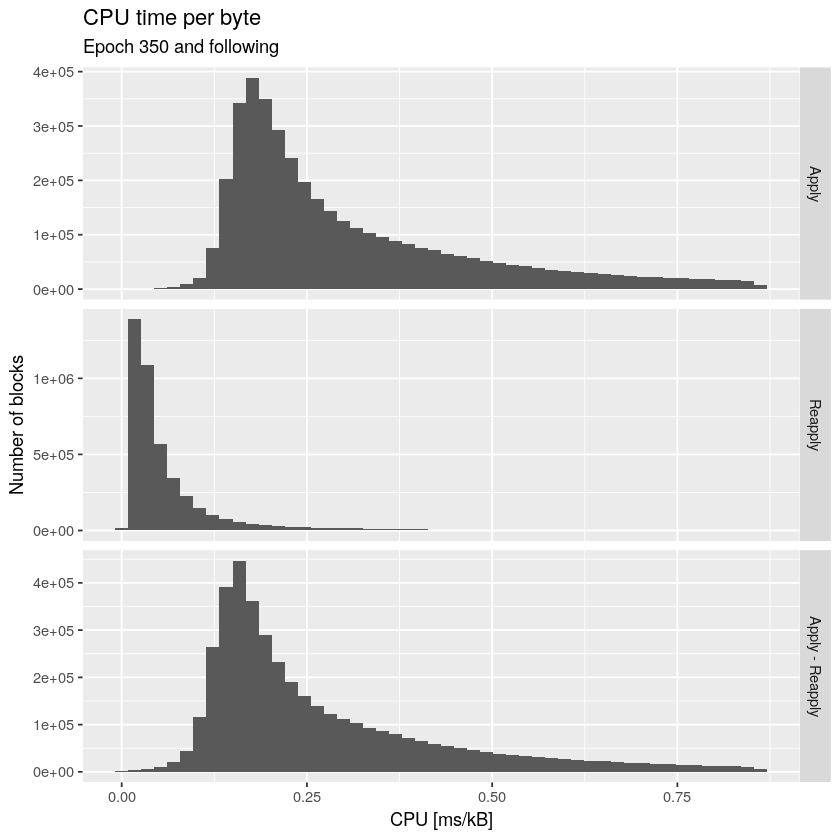

In [14]:
ggplot(melted[`CPU [ms/kB]` > 0 & `CPU [ms/kB]` < melted[, quantile(`CPU [ms/kB]`, 0.95)]], aes(x=`CPU [ms/kB]`)) +
    geom_histogram(bins=50) +
    ylab("Number of blocks") + 
    facet_grid(`Metric` ~ ., scales="free_y") +
    ggtitle(
        "CPU time per byte",
        "Epoch 350 and following"
    )

In [15]:
ggsave("cpu-per-kb.png", units="in", dpi=150, width=16, height=8)

In [16]:
melted[, .(`Median CPU [ms/kB]`=median(`CPU [ms/kB]`)), .(`Metric`)]

Metric,Median CPU [ms/kB]
<fct>,<dbl>
Apply,0.26078661
Reapply,0.03765037
Apply - Reapply,0.21913113


## Linear model

### Independent variables: transaction count and size

In [17]:
model <- lm(
    `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]`, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`]
)
model %>% summary


Call:
lm(formula = `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]`, 
    data = timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & 
        `Reapply CPU [ms]` <= `Apply CPU [ms]`])

Residuals:
    Min      1Q  Median      3Q     Max 
-56.901  -1.036   0.069   1.499  53.551 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
`Tx count`     1.740e-01  1.996e-04   871.9   <2e-16 ***
`Tx size [kB]` 1.207e-01  9.464e-05  1275.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.672 on 4363785 degrees of freedom
Multiple R-squared:  0.8451,	Adjusted R-squared:  0.8451 
F-statistic: 1.191e+07 on 2 and 4363785 DF,  p-value: < 2.2e-16


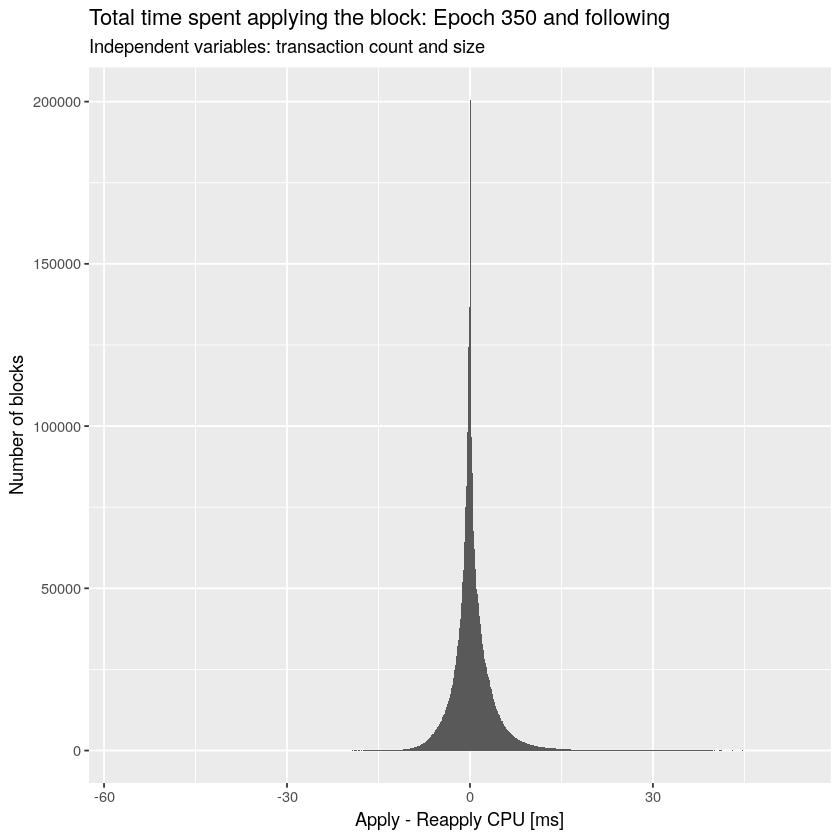

In [18]:
ggplot(data.table(`Actual - Fit [ms]`=residuals(model)), aes(`Actual - Fit [ms]`)) +
    geom_histogram(binwidth=0.1) +
    xlab("Apply - Reapply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count and size"
    )

The resulting model for validating a block (signature checking and running Plutus scripts) is:

```
(validation time) ~ 174.0 μs/tx * (Number of transactions) + 120.7 μs/kB * (size of transactions)
```

### Independent variables: transaction count, size, and execution steps

In [19]:
model <- lm(
    `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]` + `Tx exec [step]`, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`]
)
model %>% summary


Call:
lm(formula = `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]` + 
    `Tx exec [step]`, data = timings[`Tx count` > 0 & `Apply CPU [ms]` <= 
    timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`])

Residuals:
    Min      1Q  Median      3Q     Max 
-44.207  -0.618   0.179   1.220  53.682 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
`Tx count`       1.556e-01  1.738e-04   895.5   <2e-16 ***
`Tx size [kB]`   4.003e-02  1.061e-04   377.2   <2e-16 ***
`Tx exec [step]` 8.468e-10  7.061e-13  1199.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.184 on 4363784 degrees of freedom
Multiple R-squared:  0.8835,	Adjusted R-squared:  0.8835 
F-statistic: 1.103e+07 on 3 and 4363784 DF,  p-value: < 2.2e-16


In [20]:
timingsFit <- cbind(
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`],
    data.table(`Residual [ms]`=residuals(model))
)
timingsFit %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836998   Min.   : 1.022   Min.   :  1.00   Min.   : 0.159  
 1st Qu.: 89315370   1st Qu.: 8.288   1st Qu.:  5.00   1st Qu.: 7.423  
 Median :112964767   Median :23.227   Median : 11.00   Median :22.366  
 Mean   :113100715   Mean   :33.033   Mean   : 15.11   Mean   :32.173  
 3rd Qu.:136901996   3rd Qu.:52.802   3rd Qu.: 21.00   3rd Qu.:51.951  
 Max.   :161151612   Max.   :90.061   Max.   :385.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]   Reapply CPU [ms] Apply - Reapply CPU [ms]
 Min.   :0.000e+00   Min.   : 0.356   Min.   : 0.073   Min.   : 0.000          
 1st Qu.:6.689e+08   1st Qu.: 2.622   1st Qu.: 0.403   1st Qu.: 2.140          
 Median :2.297e+09   Median : 6.137   Median : 0.741   Median : 5.279          
 Mean   :3.482e+09   Mean   : 7.994   Mean   : 1.042   Mean   : 6.952          
 3rd Qu.:5.336e+09   3rd Qu.:11.907   3rd Qu.: 1.399   3rd Qu.:10.393          
 Max.   :3.625e+

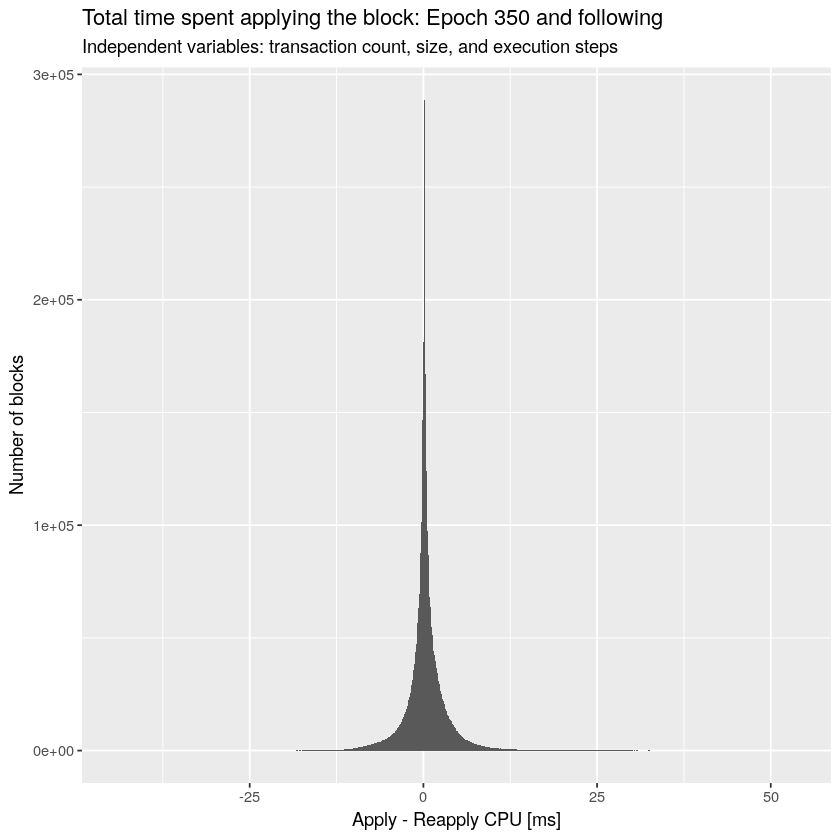

In [21]:
ggplot(timingsFit, aes(x=`Residual [ms]`)) +
    geom_histogram(binwidth=0.1) +
    xlab("Apply - Reapply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

In [22]:
ggsave("residual-histogram.png", units="in", dpi=150, width=16, height=8)

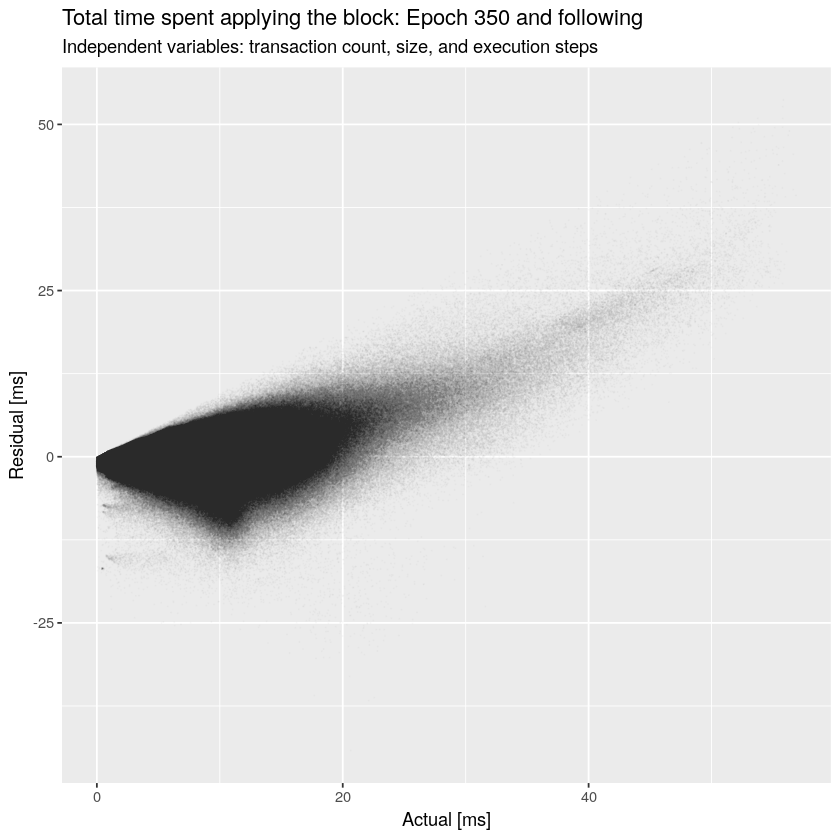

In [23]:
ggplot(
    timingsFit[, .(`Actual [ms]`=`Apply - Reapply CPU [ms]`, `Residual [ms]`)],
    aes(x=`Actual [ms]`, y=`Residual [ms]`)
) +
    geom_point(size=0.025, alpha=0.01) +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

In [24]:
ggsave("residual-scatterplot.png", units="in", dpi=150, width=16, height=8)

The previous plot indicates that nonlinear terms are present, and that a more sophisticate model might be possible, though we do not pursue this.

It turns out that the distribution of residuals are fit pretty well by a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) with location 0 and scale 1.25. We ignore heteroscedasticity.

In [25]:
b <- 1.25

In [26]:
errorModel <- data.table(`Residual [ms]`=-300:300/10, `Fit`=nrow(timingsFit)*dlaplace(-300:300/10, 0, b))

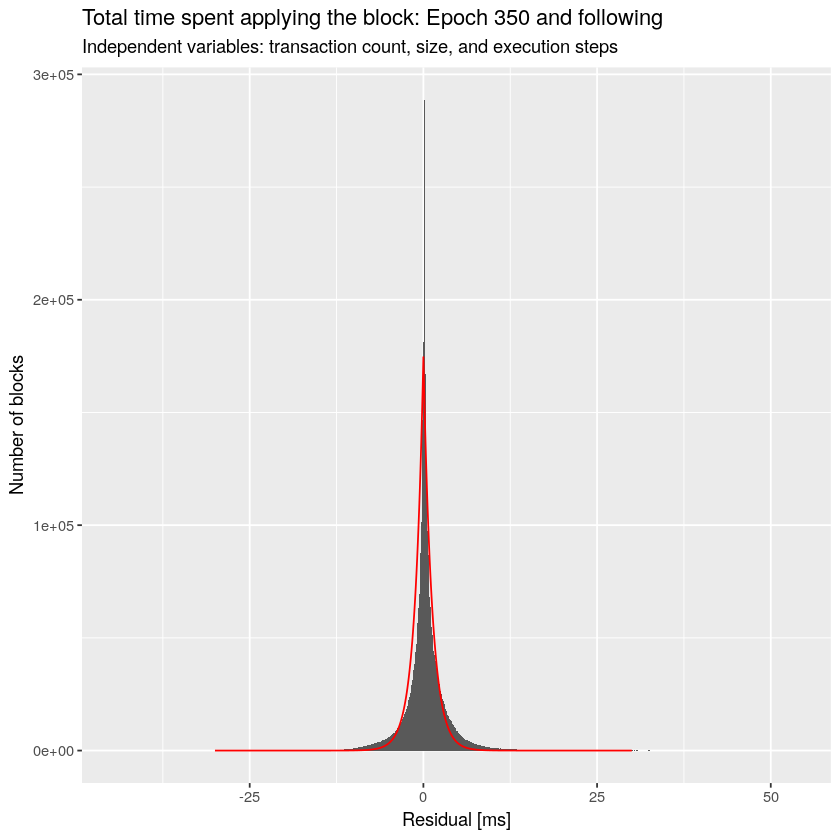

In [27]:
ggplot(timingsFit, aes(x=`Residual [ms]`)) +
    geom_histogram(binwidth=0.1) +
    geom_line(data=errorModel, aes(x=`Residual [ms]`, y=0.1*`Fit`), color="red") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

In [28]:
ggsave("residual-histogram-fit.png", units="in", dpi=150, width=16, height=8)

The resulting model for validating a block (signature checking and running Plutus scripts) is:

```
(validation time) ~ 155.6 μs/tx * (Number of transactions)
                  +  40.0 μs/kB * (size of transactions) 
                  + 846.8 μs/Gstep * (Plutus execution steps)
                  + (Laplace-distributed random variable with location 0 ms and scale 1.25 ms)
```

## Outliers

In [29]:
recentMax <- timings[`Slot` >= 160000000 & `Apply CPU [ms]` >= timings[`Slot` >= 160000000, max(`Apply CPU [ms]`)]]
recentMax

Slot,Block [kB],Tx count,Tx size [kB],Tx exec [step],Apply CPU [ms],Reapply CPU [ms],Apply - Reapply CPU [ms]
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
160444814,34.951,17,34.109,1810937370,2020.39,3432.924,-1412.534


This is [block 12100125](https://cexplorer.io/block/347993f8c93aa95a088c77732d054458597275e085bfdc9f00814e73e6f37000). Opening it in an explorer reveals that it contains several transactions with large number of NFTs and several Plutus scripts. Indeed, it did [propagate slowly](https://pooltool.io/realtime/12100125). Apparently, this is caused by [Cardano Ledger issue #3034](https://github.com/IntersectMBO/cardano-ledger/issues/3034).

Are these measures repeatable?

```bash
(
    for i in {1..10}
    do
        db-analyser --db node.db --analyse-from 160444759 --benchmark-ledger-ops --num-blocks-to-process 3 cardano --config node.json 2>/dev/null
    done
) | sed -n -e '1p;/160444814/p' | cut -f 1,3,4,5
```

```console
slot          totalTime     mut     gc
160444814       1891312 1451039 440273
160444814       1856810 1423818 432992
160444814       1860984 1424315 436668
160444814       1865990 1434216 431773
160444814       1864201 1427403 436798
160444814       1864993 1426206 438786
160444814       1875604 1430147 445457
160444814       1891785 1445674 446110
160444814       1878727 1435415 443311
160444814       1850210 1417927 432283
```

These results also provide a sense of how noisy the measurements are.

## Findings

We completed the basic analysis of block and transaction validation times for Cardano `mainnet` since Epoch 350. Results differ significantly from the preliminary results because it was discovered that `db-analyser` output is not reliable when it is run on a machine that has other CPU load: the new analysis is based on a clean dataset that was run on an otherwise idle machine.

1. The `db-analyser` tool can be used to measure the Cardno block-application time, either including or not including verifying transaction signatures and running Plutus scripts.
2. Ideally, `db-analyser` could be modified to report CPU times for phase 1 and phase 2 validation on a per-transaction basis.
3. The output of this tool is quite noisy and does not include enough of the explanatory variable for predicting CPU times for transactions or blocks.
4. The missing explanatory variables (size of UTxO set, number of inputs, number of outputs, etc.) can be extracted from the ledger or `cardano-db-sync`.
5. For transaction signature verification and Plutus script execution, the median times are . . .
    - 436.5 μs/tx
    - 219.1 μs/kB
    - Jointly via a linear model, 174.0 μs/tx plus 120.7 μs/kB.
    - Jointly via a linear model, 155.6 μs/tx plus 40.0 μs/kB plus 846.8 μs/Gstep, with a Lapace-distributed error having location 0 μs and scale 1250 μs.
6. The results above are qThe noise in the data and the uncertainty in predictions make the above values unsuitable for estimating individual transactions but suitable for bulk estimates of many blocks.
7. A more sophisticated double general linear model could be used to generate artificial transaction workloads.
8. The CPU-timing parameters in the default configuration for Leios simulations could be reduced based on this work.